In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings

np.random.seed = 42

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, roc_auc_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, OneHotEncoder, KBinsDiscretizer, label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

In [4]:
X_dev, X_test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Diabetes_012'])

In [5]:
colors = ['#602CA3', '#FE4680', '#FE9B06']

### Feature engineering

In [6]:
def bin_BMI(data):
    bins = [0, 18.5, 24.9, 29.9, float('inf')]
    labels = ['Underweight', 'Healthy weight', 'Overweight', 'Obesity']
    data['binned_BMI'] = pd.cut(data['BMI'], bins=bins, labels=labels)
    data['binned_BMI'] = data['binned_BMI'].cat.codes
    return data

def calculate_OverallHealthStatus(data):
    weights = {'GenHlth': 0.7, 'MentHlth': 0.01, 'PhysHlth': 0.01}
    weighted_scores = data[['GenHlth', 'MentHlth', 'PhysHlth']] * pd.Series(weights)
    data['OverallHealthStatus'] = weighted_scores.sum(axis=1)
    return data

def calculate_OverallHealthRisk(data):
    weights = {'HighBP': 1.3, 'HighChol': 1, 'Stroke': 0.8, 'HeartDiseaseorAttack': 1.3}
    weighted_scores = data[['HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack']] * pd.Series(weights)
    data['OverallHealthRisk'] = weighted_scores.sum(axis=1)
    return data

def calculate_OverallHealthRisk_CDC(data):
    data['OverallHealthRisk_CDC'] = data[['BMI', 'Age', 'PhysActivity']].mean(axis=1)
    return data

def identify_NutritiousFood(data):
    data['NutritiousFood'] = (data['Fruits'].astype(bool) & data['Veggies'].astype(bool)).astype(int)
    return data

def identify_BadHabits(data):
    data['BadHabits'] = (data['Smoker'].astype(bool) & data['HvyAlcoholConsump'].astype(bool)).astype(int)
    return data

def deleteRepeated(data):
    data.drop(['GenHlth', 'MentHlth', 'PhysHlth', 'HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack', 'BMI', 'Age', 'PhysActivity', "Fruits", 
               "Veggies", "Smoker", 'HvyAlcoholConsump'], axis=1, inplace=True)
    return data

feature_engineering_pipeline = Pipeline([
    ('bin_BMI', FunctionTransformer(bin_BMI)),
    ('calculate_OverallHealthStatus', FunctionTransformer(calculate_OverallHealthStatus)),
    ('calculate_OverallHealthRisk', FunctionTransformer(calculate_OverallHealthRisk)),
    ('calculate_OverallHealthRisk_CDC', FunctionTransformer(calculate_OverallHealthRisk_CDC)),
    ('identify_NutritiousFood', FunctionTransformer(identify_NutritiousFood)),
    ('identify_BadHabits', FunctionTransformer(identify_BadHabits)),
    ('deleteRepeated', FunctionTransformer(deleteRepeated))
])

In [7]:
X_dev = feature_engineering_pipeline.transform(X_dev)

In [8]:
y = np.array(X_dev['Diabetes_012'])
X = X_dev.drop(['Diabetes_012'],axis=1)

y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = 3

X_train, X_val, y_train, y_val = train_test_split(X, y_bin, test_size=0.33, random_state=0)

In this part of the project, we assess how various models perform with our data. Our comparative measure is the ROC_AUC (Receiver Operating Characteristic Area Under the Curve), one versus the rest.

The models we are evaluating are:
* OneVsRestClassifier SVC
* Linear Discriminant Analysis (LDA)
* Quadratic Discriminant Analysis (QDA)
* K Neighbors Classifier (k-NN)
* Multinomial Logistic Regression
* Decision Tree
* Random Forest
* Gaussian Naive Bayes
* Gradient Boosting for classification
* AdaBoost classifier
* XGBoost
* Multi-layer Perceptron classifier


### Models

#### OneVsRestClassifier SVC

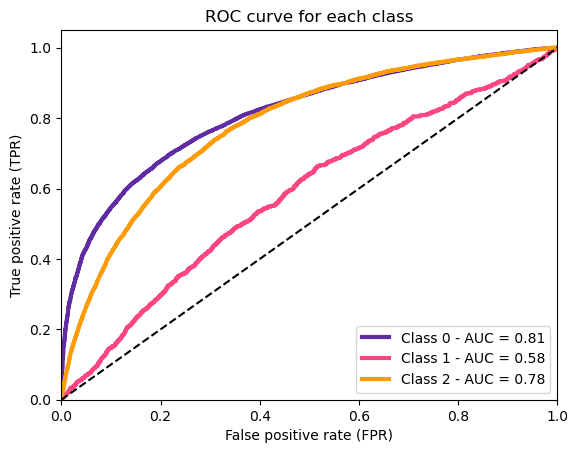

In [9]:
clf = OneVsRestClassifier(LinearSVC(random_state=0))

y_score = clf.fit(X_train, y_train).decision_function(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

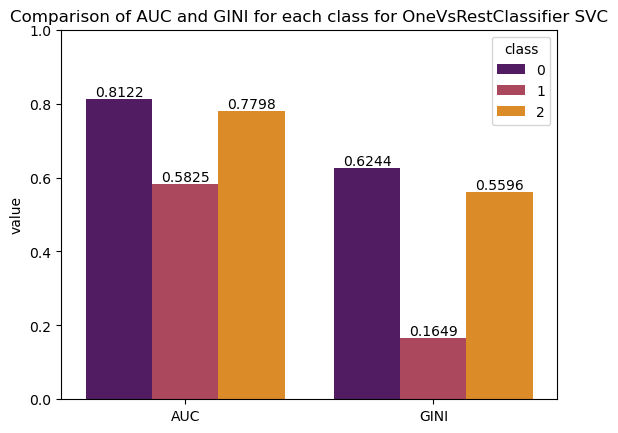

In [10]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1

ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylim(0, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for OneVsRestClassifier SVC")
plt.show()

#### Linear Discriminant Analysis (LDA)

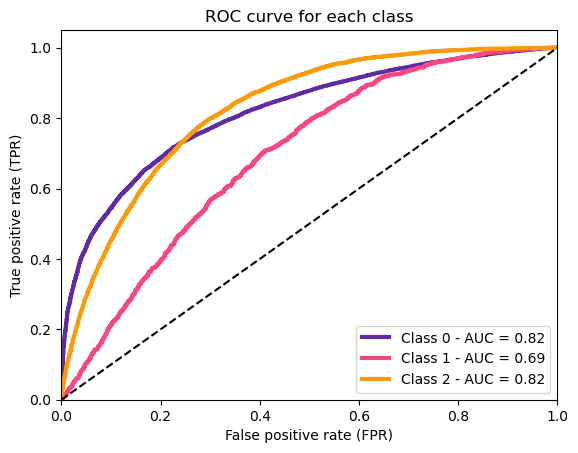

In [90]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train.argmax(axis=1))

y_score = lda.decision_function(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

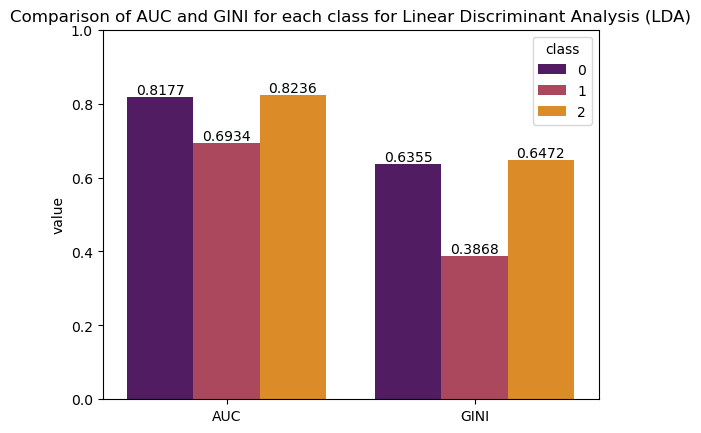

In [91]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1

ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylim(0, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for Linear Discriminant Analysis (LDA)")
plt.show()

#### Quadratic Discriminant Analysis (QDA)

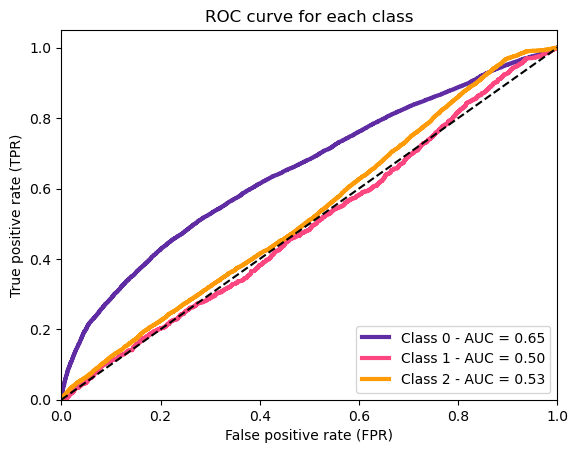

In [92]:
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train, y_train.argmax(axis=1))

y_score = qda.decision_function(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

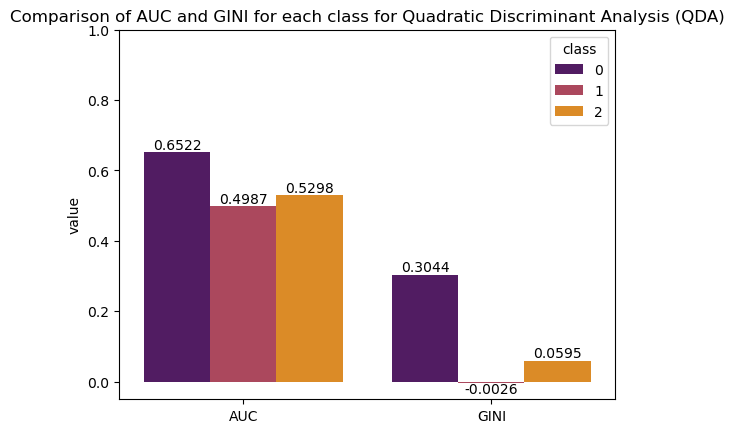

In [93]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1

ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylim(-0.05, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for Quadratic Discriminant Analysis (QDA)")
plt.show()

#### K Neighbors Classifier (k-NN)

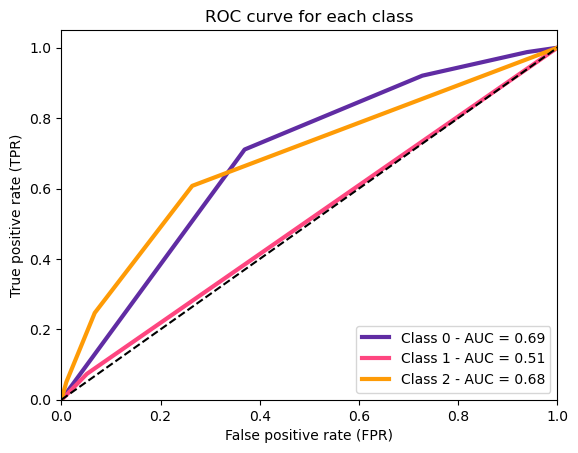

In [94]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train.argmax(axis=1))

y_score = knn.predict_proba(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

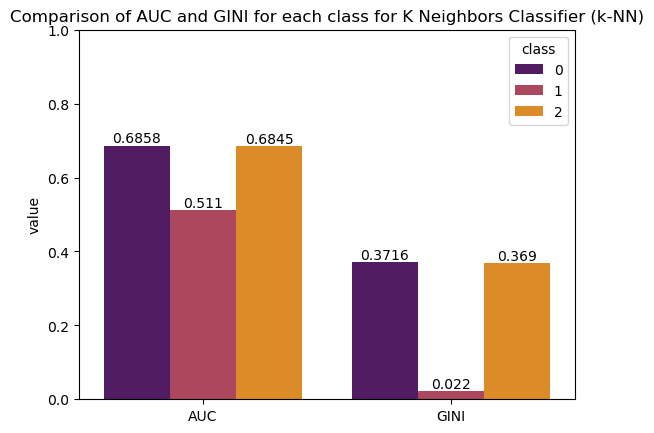

In [95]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1

ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylim(0, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for K Neighbors Classifier (k-NN)")
plt.show()

#### Multinomial Logistic Regression

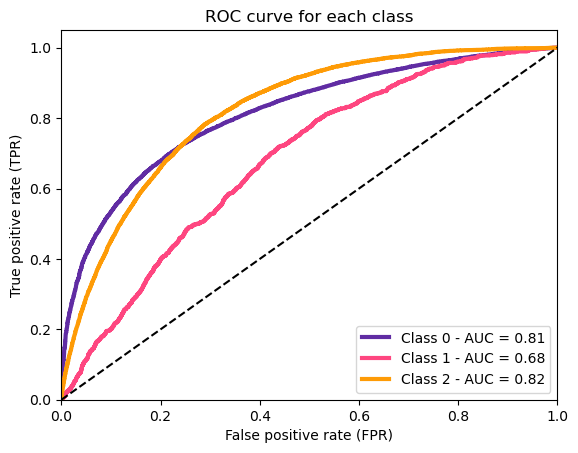

In [9]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
clf.fit(X_train, y_train.argmax(axis=1))  # Użyj jednowymiarowej tablicy etykiet

y_score = clf.predict_proba(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

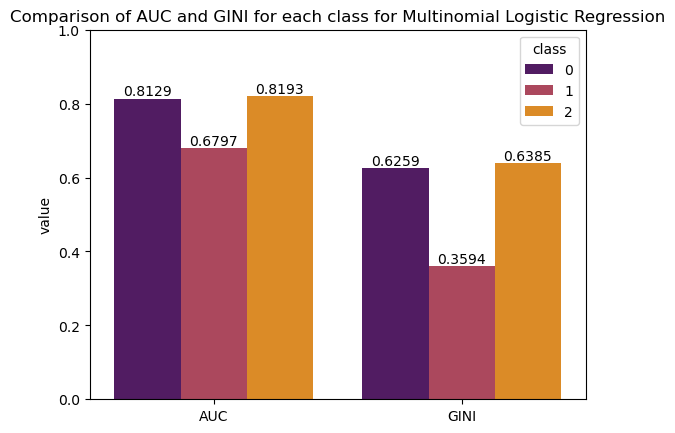

In [12]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1

ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])

plt.ylim(0, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for Multinomial Logistic Regression")
plt.show()

#### Decision Tree

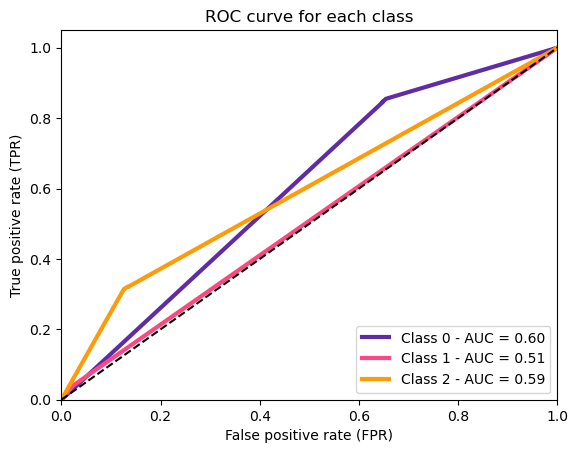

In [98]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

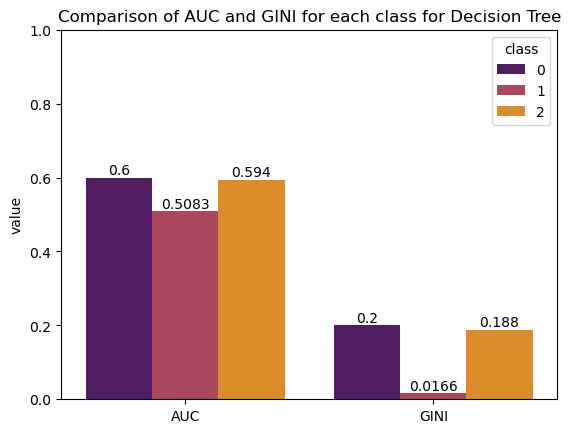

In [99]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1


ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylim(0, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for Decision Tree")
plt.show()

#### Random Forest

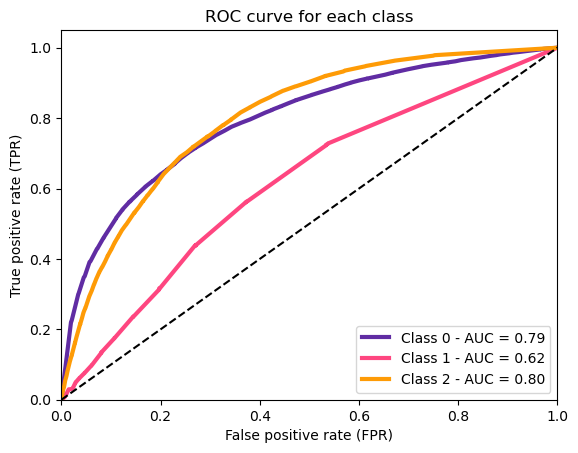

In [100]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

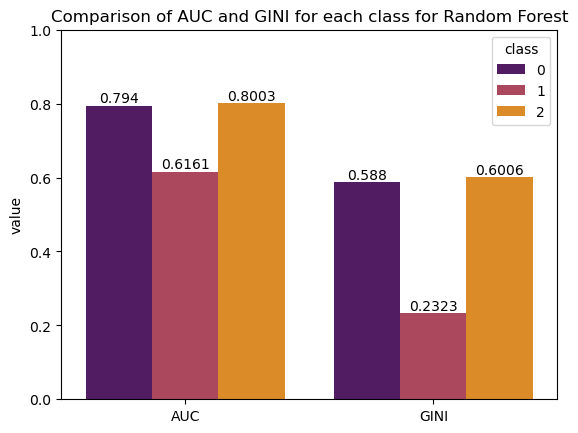

In [101]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1


ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylim(0, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for Random Forest")
plt.show()

#### Gaussian Naive Bayes

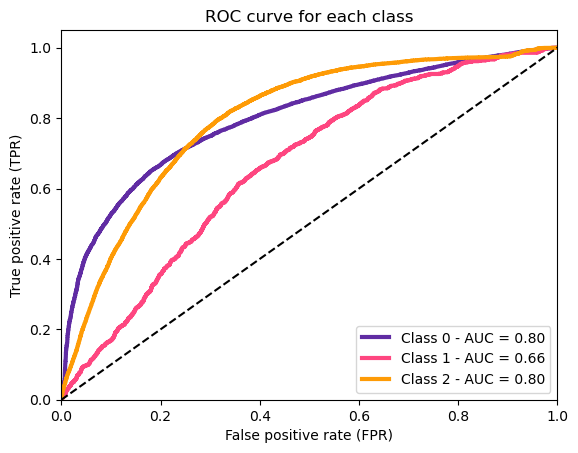

In [102]:
clf = GaussianNB()

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

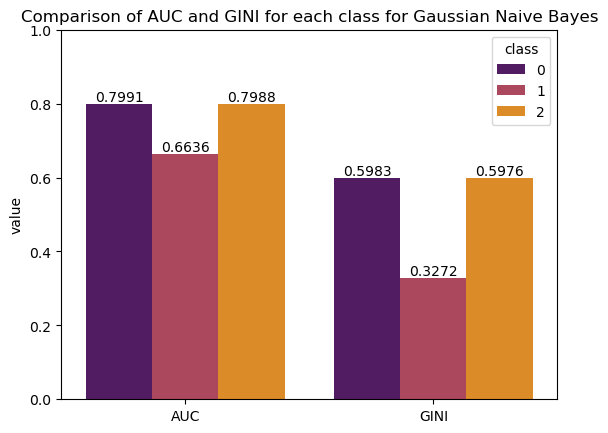

In [103]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1

ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylim(0, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for Gaussian Naive Bayes")
plt.show()

#### Gradient Boosting for classification

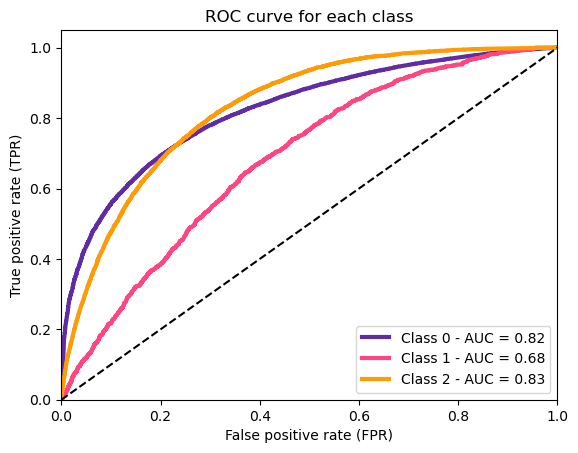

In [104]:
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.decision_function(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

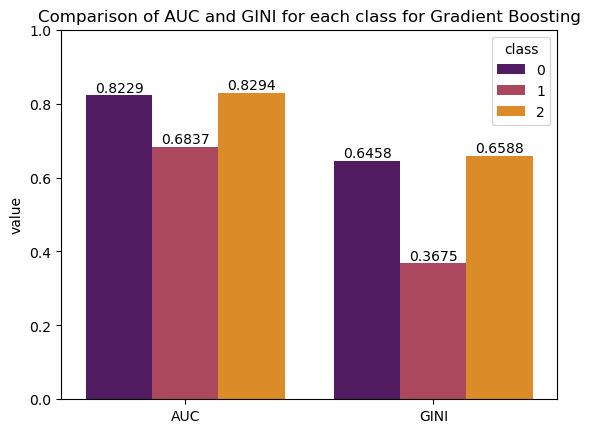

In [105]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1


ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylim(0, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for Gradient Boosting")
plt.show()

#### AdaBoost classifier

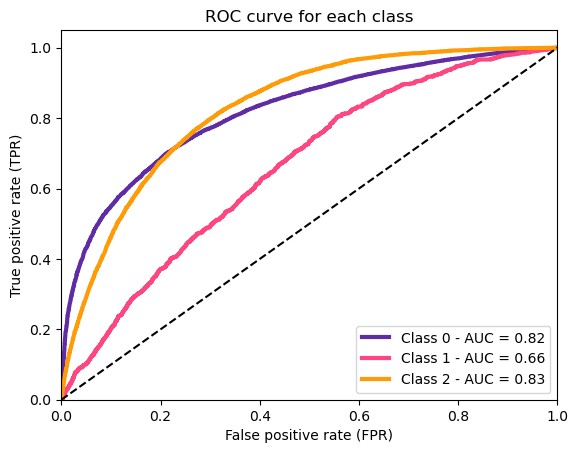

In [106]:
clf = AdaBoostClassifier()

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.decision_function(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

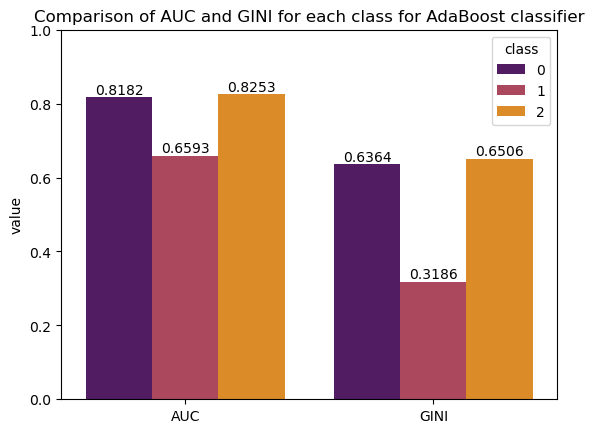

In [107]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1


ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylim(0, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for AdaBoost classifier")
plt.show()

#### XGBoost

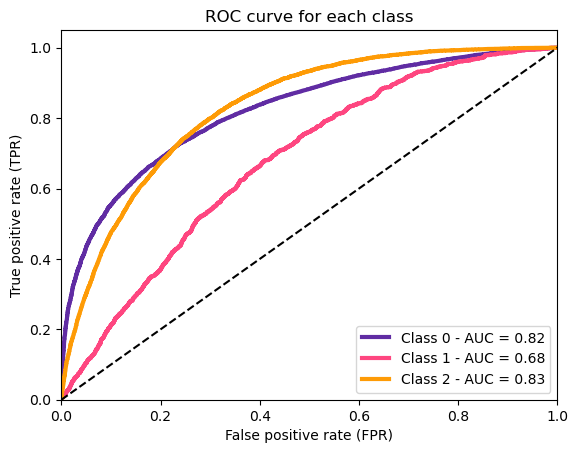

In [108]:
clf = XGBClassifier()

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

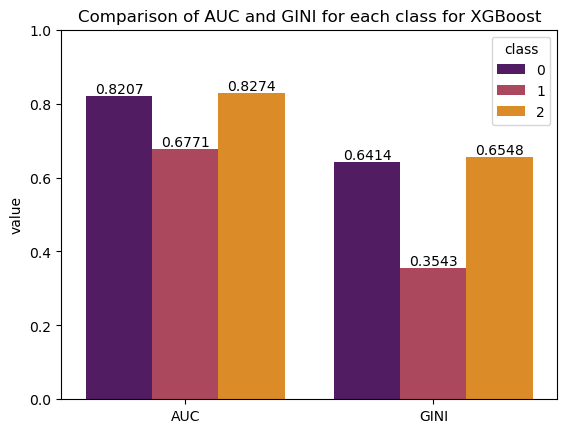

In [109]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1


ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylim(0, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for XGBoost")
plt.show()

#### Multi-layer Perceptron classifier

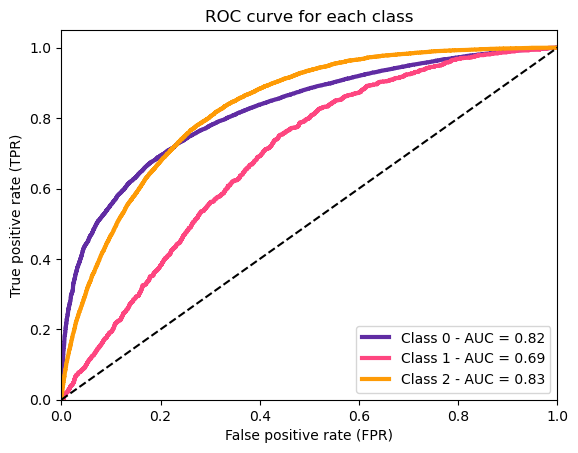

In [10]:
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, activation='relu', solver='adam', random_state=0)

clf.fit(X_train, y_train.argmax(axis=1))

y_score = clf.predict_proba(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} - AUC = {roc_auc[i]:.2f}', color=colors[i], lw = 3)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC curve for each class')
plt.legend(loc='lower right')

plt.show()

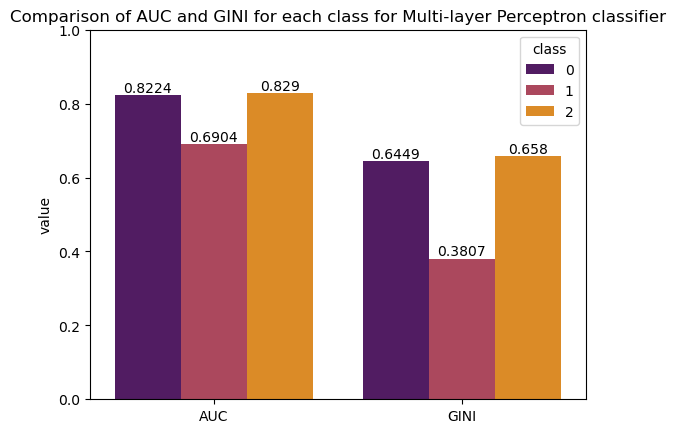

In [111]:
bl = pd.DataFrame(0, index=range(6), columns=range(3))
bl.columns = ["class", "error", "value"]
j = 0
for i in range(n_classes):
    AUC = roc_auc_score(y_val[:, i], y_score[:, i], multi_class='ovo')
    gini = 2*AUC - 1
    
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "AUC", AUC
    j+=1
    bl["class"][j], bl["error"][j], bl["value"][j] = i, "GINI", gini
    j+=1


ax = sns.barplot(x= bl["error"], y=bl["value"].round(4), data=bl, palette='inferno', hue=bl["class"].astype(str))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.ylim(0, 1)
plt.xlabel(None)
plt.title("Comparison of AUC and GINI for each class for Multi-layer Perceptron classifier")
plt.show()

### Summary

There is a certain group of models whose results are particularly poor in terms of specificity for class 1 (prediabetes), including models Quadratic Discriminant Analysis (QDA) and K Neighbors Classifier (k-NN). We also have a group of promising models such as Gradient Boosting for classification, AdaBoost classifier, XGBoost and Multi-layer Perceptron classifier.